### 2021_11_11_4

In [1]:
import os

In [2]:
!ls -al "../DATA/dogs-vs-cats/train/" | head -5
!ls -l "../DATA/dogs-vs-cats/train/" | grep ^- | wc -1
!ls -al "../DATA/dogs-vs-cats/test" | head -5
!ls -l "../DATA/dogs-vs-cats/test" | grep ^- | wc -1

total 1217008
drwxr-xr-x@ 25002 seungwoomun  staff  800064  9 20  2013 .
drwx------@     9 seungwoomun  staff     288 11 11 10:27 ..
-rw-r--r--@     1 seungwoomun  staff   12414  9 20  2013 cat.0.jpg
-rw-r--r--@     1 seungwoomun  staff   16880  9 20  2013 cat.1.jpg
wc: illegal option -- 1
usage: wc [-clmw] [file ...]
ls: ../DATA/dogs-vs-cats/test: No such file or directory
ls: ../DATA/dogs-vs-cats/test: No such file or directory
wc: illegal option -- 1
usage: wc [-clmw] [file ...]


In [8]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
ori_dataset_dir = '../DATA/dogs-vs-cats/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = '../DATA/dogs-vs-cats/dogs_and_cats_small'

In [9]:
# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')

val_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 검증용 고양이 사진 디렉터리
val_cats_dir = os.path.join(val_dir, 'cats')

# 검증용 강아지 사진 디렉터리
val_dogs_dir = os.path.join(val_dir, 'dogs')

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')

### [훈련/검증/테스트]에 들어있는 사진의 개수를 카운트

In [10]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(val_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(val_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


### 사전 훈련 네트워크 가져오기

In [11]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = "imagenet", 
                  include_top = False, # 완전 연결 계층(FCL)
                  input_shape = (150, 150, 3))

Using TensorFlow backend.
2021-11-11 13:26:08.273520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58892288/58889256 [==============================] - 5s 0us/step


* VGG16 함수에 세 개의 매개변수를 전달
    * weights는 모델을 초기화할 가중치 체크포인트를 지정
        * None, 'imagenet', weights의 path
    * include_top은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정.
        * 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함.
        * 여기서는 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가할 계획.
    * input_shape은 네트워크에 주입할 이미지 텐서의 크기입니다.
        * 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

* VGG16은 합성곱 13개, 완전 연결 층(FCL) 3개.
    * include_top이 기본값이 True일 경우 input_shape이 원본 모델과 동일한 (224, 224, 3)이 되어야 한다.
* 다른 모델 VGG19는 합성곱 층 16개, 완전 연결 층 3개로 이루어져 있음.

### 데이터 증식을 사용하지 않는 빠른 특성 추출

In [19]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 소규모 데이터셋을 저장할 디렉터리
base_dir = '../DATA/dogs-vs-cats/dogs_and_cats_small'

# 데이터 디렉터리
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

### 이미지 제너레이터를 활용한 데이터 가져오기

In [20]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))

    print("피처, 레이블 : ", features.shape, labels.shape  )

    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        #print(  type(features_batch), features_batch.shape  )
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 
            # 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    #print(  type(features), features_batch.shape  )
    return features, labels

In [21]:
t_features, t_labels = extract_features(train_dir, 100)
print( t_features.shape, t_labels.shape )

피처, 레이블 :  (100, 4, 4, 512) (100,)
Found 2000 images belonging to 2 classes.
(100, 4, 4, 512) (100,)


In [22]:
%%time

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

피처, 레이블 :  (2000, 4, 4, 512) (2000,)
Found 2000 images belonging to 2 classes.
피처, 레이블 :  (1000, 4, 4, 512) (1000,)
Found 1000 images belonging to 2 classes.
피처, 레이블 :  (1000, 4, 4, 512) (1000,)
Found 1000 images belonging to 2 classes.
CPU times: user 30min 49s, sys: 2min 55s, total: 33min 44s
Wall time: 4min 25s


In [23]:
print( train_features.shape, train_labels.shape )
print( validation_features.shape, validation_labels.shape )
print( test_features.shape, test_labels.shape )

(2000, 4, 4, 512) (2000,)
(1000, 4, 4, 512) (1000,)
(1000, 4, 4, 512) (1000,)


* 추출된 특성(데이터)의 크기는 (samples, 4, 4, 512). 완전 연결 분류기에 주입하기 위해 먼저 (samples, 8192)크기로 펼치기

In [24]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 완전 연결 분류기 정의(FCL)
* 완전 연결 분류기(FCL)를 정의
* 신경망의 규제를 위해 드롭아웃을 사용.
* 저장된 데이터와 레이블을 사용해 훈련

In [25]:
from tensorflow.keras import models, layers, optimizers

In [26]:
%%time

# 완전 연결층
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
100/100 [==============================] - 2s 21ms/step - loss: 0.5956 - acc: 0.6770 - val_loss: 0.4491 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 2s 20ms/step - loss: 0.4203 - acc: 0.8115 - val_loss: 0.3662 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 2s 19ms/step - loss: 0.3520 - acc: 0.8520 - val_loss: 0.3448 - val_acc: 0.8490
Epoch 4/30
100/100 [==============================] - 2s 19ms/step - loss: 0.3177 - acc: 0.8680 - val_loss: 0.3007 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2843 - acc: 0.8840 - val_loss: 0.2836 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2607 - acc: 0.8880 - val_loss: 0.2743 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2497 - acc: 0.9020 - val_loss: 0.2632 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 2s 19ms/step - 

* FCL(완전 연결층)2개의 Dense 층만 처리하면 되기 때문에 훈련이 빠르다.
    * 합성곱 층의 가중치는 사전 훈련 네트워크 가중치 이용.
    * 데이터가 늘어날 경우 정확도가 올라간다.

### 훈련 손실과 정확도 곡선

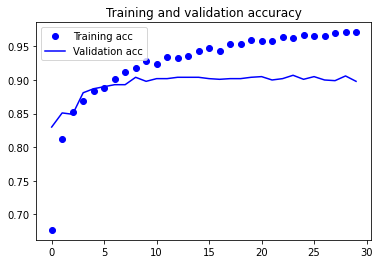

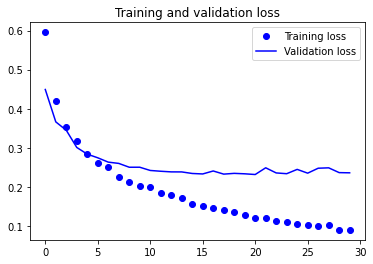

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Summary
* validation 90%의 검증 정확도에 도달
* 앞에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋음.
* 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것
    * 과대적합의 이유 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않음.

### 모델 저장

In [28]:
model.save('./Model/cats_dogs_small_3_VGG_30_epoch.h5')

### 미세 조정 - 일부 훈련
* 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정
* 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제한다.
    * 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것.
    * 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부른다.
    
* 같은 이유로 맨 위에 있는 분류기가 훈련된 후에 합성곱 기반의 상위 층을 미세 조정 가능.
* 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됩니다.

    * 미세 조정될 층들이 사전에 학습한 표현들을 망가뜨리게 될 것입니다.
    * 네트워크를 미세 조정하는 단계:
        * 01 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
        * 02 훈련된 기반 네트워크를 동결합니다.
        * 03 새로 추가한 네트워크를 훈련합니다.
        * 04 기반 네트워크에서 일부 층의 동결을 해제합니다.
        * 05 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.
* 처음 세 단계는 특성 추출을 할 때 이미 완료했습니다.
* 네 번째 단계를 진행해 보죠. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다.

In [29]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

* 마지막 세 개의 합성곱 층을 미세 조정하겠습니다.
    * 즉, block4_pool까지 모든 층은 동결
    * block5_conv1, block5_conv2, block5_conv3 층은 학습 대상

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

batch_size = 20
epochs = 30

In [33]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [34]:
%%time

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # total_train // batch_size
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  # total_val // batch_size
      verbose=1)

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50


ValueError: in user code:


    ValueError: `logits` and `labels` must have the same shape, received ((None, None, None, 1) vs (None, 1)).
